# Project description

**Project Objective:**  
The main objective of this project is to predict monthly overnight stays in all hotels in Switzerland. 

**Data**  
The data ranges from January 2005 to December 2022. The data used comes from multiple sources. All datasets are joined on the 'date' column.

Here's an example of the format of the final dataframe:

| Date    | Overnight Stays | Feature 1 | Feature 2 | ... |
|---------|-----------------|-----------|-----------|-----|
| 2005-01 | 12345           | value1    | value2    | ... |
| 2005-02 | 23456           | value3    | value4    | ... |
| ...     | ...             | ...       | ...       | ... |

**Methodology**

We will be using linear Regressions (Ridge & Lasso), Autoregressive Models, a Random Forest and a Neural Network for time series prediction. In the end the best Model will be picked based on an evaluation using the Mean Squared Errors (MSE).

**Expected Outcomes**

The expected outcome of this project is a model that can accurately predict the number of overnight stays in Swiss hotels based on historical data and relevant features.

**Next Steps**

The Project is structured in the following four steps:

- Data Preprocessing
- Seasonally Adjusting
- Model Training
- Model Evaluation

# Data Preprocessing

In [1]:
# importing all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from pmdarima import auto_arima
import seaborn as sns
from prophet import Prophet
import random


# Use a nicer style for plots
plt.style.use("seaborn-v0_8-muted")

## Target Value (overnight stays)
All other datasets will be merged to this one. The datasets always need to have 216 rows with the date format 2005-01, so we can merge everything else on this column called 'date'.

In [2]:
# Read the csv
df = pd.read_csv("./data/BfS_Total_overnight_stays_monthly.csv")

# change the name of the column
df = df.rename(columns={'Herkunftsland - Total Logiernachte': 'Total_overnight_stays'})

# replace month values with numbers
# Create a dictionary to map month names to numbers
month_to_number = {
    'Januar': 1,    
    'Februar': 2,
    'Marz': 3,
    'April': 4,
    'Mai': 5,
    'Juni': 6,
    'Juli': 7,
    'August': 8,
    'September': 9,
    'Oktober': 10,
    'November': 11,
    'Dezember': 12
}

# Replace the values in the 'Monat' column
df['Monat'] = df['Monat'].replace(month_to_number)

# merge them together
df['date'] = pd.to_datetime(df['Jahr'].astype(str) + '-' + df['Monat'].astype(str), format='%Y-%m')

# remove the day value
df['date'] = df['date'].dt.strftime('%Y-%m')

# drop unnecessary columns
df.drop(columns=['Jahr', 'Monat'])
df = df[['date', 'Total_overnight_stays']]

## Features
In the following Section we split the different processing steps geographically. The Region is stated in the bracket of the Title with the corresponding Database (SNB, EUROSTAT, FRED). Most of our sources come from these three Databases, although there are also others included.

### Features (Asia)

In [3]:
#importing Asia datasets:
China_CPI_index = pd.read_csv("./data/China_consumer_price_index.csv")
China_exports_dollars_seas_adj = pd.read_csv("./data/China_exports_in_dollars_seasonally_adj.csv")
China_renminbi_dollar_rate = pd.read_csv("./data/China_renminbi_to_dollar_rate.csv")

India_CPI = pd.read_csv("./data/India_cunsumer_price_index.csv")
India_electricity_prod_index = pd.read_csv("./data/India_electricity_production_index.csv")
India_GDP_index_seas_adj = pd.read_csv("./data/India_GDP_index_seasonally_adj.csv")
India_imports_dollars_seas_adj = pd.read_csv("./data/India_imports_dollars_seasonally_adj.csv")
India_net_trade_rupee_seas_adj = pd.read_csv("./data/India_net_trade_rupee_seasonally_adj.csv")
India_real_exchange_rate_dollar = pd.read_csv("./data/India_real_exchange_rate_dollar.csv")

Japan_GDP_index_seas_adj = pd.read_csv("./data/Japan_GDP_index_seasonally_adj.csv")
Japan_working_population_seas_adj = pd.read_csv("./data/Japan_working_age_population_seas_adj.csv")
Japan_90_day_interest_rate = pd.read_csv("./data/Japan_90_day_interest_rate.csv")
Japan_unemployment_rate_seas_adj = pd.read_csv("./data/Japan_unemployment_rate_seas_adj.csv")

Singapore_CPI = pd.read_csv("./data/Singapore_CPI_base_2019.csv")
Singapore_tourism_inbound_arrivals_CH = pd.read_csv("./data/Singapore_tourism_inbound_arrivals_total_and_switzerland.csv")

Features (China)

In [4]:
# change the name of the column
China_CPI_index = China_CPI_index.rename(columns={'DATE': 'date','CPALTT01CNM659N': 'China_CPI' })

# convert to pandas datetime
China_CPI_index['date'] = pd.to_datetime(China_CPI_index['date'])

# remove the day value
China_CPI_index['date'] = China_CPI_index['date'].dt.strftime('%Y-%m')

# change the name of the column
China_exports_dollars_seas_adj = China_exports_dollars_seas_adj.rename(columns={'DATE': 'date','XTEXVA01CNM667S': 'China_exports_indollars_seas_adj' })

# convert to pandas datetime
China_exports_dollars_seas_adj['date'] = pd.to_datetime(China_exports_dollars_seas_adj['date'])

# remove the day value
China_exports_dollars_seas_adj['date'] = China_exports_dollars_seas_adj['date'].dt.strftime('%Y-%m')

# change the name of the column
China_renminbi_dollar_rate = China_renminbi_dollar_rate.rename(columns={'DATE': 'date', 'EXCHUS': 'China_exchange_rate_dollar'})

# convert to pandas datetime
China_renminbi_dollar_rate['date'] = pd.to_datetime(China_renminbi_dollar_rate['date'])

# remove the day value
China_renminbi_dollar_rate['date'] = China_renminbi_dollar_rate['date'].dt.strftime('%Y-%m')

# merge them together
China_dataset = pd.merge(China_CPI_index, China_exports_dollars_seas_adj, on='date', how='left')
China_dataset = pd.merge(China_dataset, China_renminbi_dollar_rate, on='date', how='left')

Features (India)

In [5]:
India_CPI = India_CPI.rename(columns={'INDCPIALLMINMEI': 'India_CPI'})
India_electricity_prod_index = India_electricity_prod_index.rename(columns={'INDPRENEL01IXOBM': 'India_electricity_prod_index'})
India_GDP_index_seas_adj = India_GDP_index_seas_adj.rename(columns={'INDLORSGPTDSTSAM': 'India_GDP_index_seas_adj'})
India_imports_dollars_seas_adj = India_imports_dollars_seas_adj.rename(columns={'XTIMVA01INM667S': 'India_imports_dollars_seas_adj'})
India_net_trade_rupee_seas_adj = India_net_trade_rupee_seas_adj.rename(columns={'XTNTVA01INM664S': 'India_net_trade_rupee_seas_adj'})
India_real_exchange_rate_dollar = India_real_exchange_rate_dollar.rename(columns={'RBINBIS': 'India_real_exchange_rate_dollar'})

# merge them together
India_dataset = pd.merge(India_CPI, India_electricity_prod_index, on='DATE', how='left')
India_dataset = pd.merge(India_dataset, India_GDP_index_seas_adj, on='DATE', how='left')
India_dataset = pd.merge(India_dataset, India_imports_dollars_seas_adj, on='DATE', how='left')
India_dataset = pd.merge(India_dataset, India_net_trade_rupee_seas_adj, on='DATE', how='left')
India_dataset = pd.merge(India_dataset, India_real_exchange_rate_dollar, on='DATE', how='left')

# Change the name of the column
India_dataset = India_dataset.rename(columns={'DATE': 'date'})

# Convert to pandas datetime
India_dataset['date'] = pd.to_datetime(India_dataset['date'])

# Remove the day value
India_dataset['date'] = India_dataset['date'].dt.strftime('%Y-%m')

Features (Japan)

In [6]:
# Change the name of the column
Japan_GDP_index_seas_adj = Japan_GDP_index_seas_adj.rename(columns={'DATE': 'date', 'JPNLORSGPTDSTSAM': 'Japan_GDP_index_seas_adj'})
Japan_working_population_seas_adj = Japan_working_population_seas_adj.rename(columns={'DATE': 'date', 'LFWA64TTJPM647S': 'Japan_working_population_seas_adj'})
Japan_90_day_interest_rate = Japan_90_day_interest_rate.rename(columns={'DATE': 'date', 'IR3TIB01JPM156N': 'Japan_90_day_interest_rate'})
Japan_unemployment_rate_seas_adj = Japan_unemployment_rate_seas_adj.rename(columns={'DATE': 'date', 'LRUN64TTJPM156S': 'Japan_unemployment_rate_seas_adj'})

# Merge them together
Japan_dataset = pd.merge(Japan_GDP_index_seas_adj, Japan_working_population_seas_adj, on='date', how='left')
Japan_dataset = pd.merge(Japan_dataset, Japan_90_day_interest_rate, on='date', how='left')
Japan_dataset = pd.merge(Japan_dataset, Japan_unemployment_rate_seas_adj, on='date', how='left')

# Convert to pandas datetime
Japan_dataset['date'] = pd.to_datetime(Japan_dataset['date'])

# Remove the day value
Japan_dataset['date'] = Japan_dataset['date'].dt.strftime('%Y-%m')

Features (Singapore)

In [7]:
# drop rows with dataframe description
Singapore_CPI = Singapore_CPI.loc[9:224]
Singapore_tourism_inbound_arrivals_CH = Singapore_tourism_inbound_arrivals_CH.loc[9:224]

# invert order
Singapore_tourism_inbound_arrivals_CH = Singapore_tourism_inbound_arrivals_CH[::-1]

# rename columns
Singapore_CPI = Singapore_CPI.rename(columns={'Unnamed: 0': 'date', 'Unnamed: 1': 'Singapore_CPI'})

#in this step there is a fault happening in vscode
Singapore_tourism_inbound_arrivals_CH = Singapore_tourism_inbound_arrivals_CH.rename(columns={'Unnamed: 0': 'date', 'Unnamed: 1': 'Singapore_total_arrivals', 'Unnamed: 2': 'Singapore_arrivals_Switzerland'})

# merge them together
Singapore_dataset = pd.merge(Singapore_CPI, Singapore_tourism_inbound_arrivals_CH, on='date', how='left')

# Convert to pandas datetime
Singapore_dataset['date'] = pd.to_datetime(Singapore_dataset['date'], format='  %Y %b')

# Remove the day value
Singapore_dataset['date'] = Singapore_dataset['date'].dt.strftime('%Y-%m')

Merging (Asia)

In [8]:
Asia_dataset = pd.merge(China_dataset, India_dataset, on='date', how='left')
Asia_dataset = pd.merge(Asia_dataset, Japan_dataset, on='date', how='left')
#Asia_dataset = pd.merge(Asia_dataset, Singapore_dataset, on='date', how='left')

Asia_dataset.isnull().sum().sum()

0

### Features (Switzerland / SNB Database)

In [9]:
#SNB Real Exchange Rates
# Import DataFrame
snb_exchange = pd.read_csv("./data/snb_exchange.csv", delimiter=";", skiprows = 3)

# Drop unnecessary columns
columns_to_drop = [snb_exchange.columns[1], snb_exchange.columns[2]]
snb_exchange = snb_exchange.drop(columns_to_drop, axis=1)

# convert to DateTime
snb_exchange["Date"] = pd.to_datetime(snb_exchange["Date"], format="%Y-%m").dt.to_period('M')

# convert to WideFormat
snb_exchange = snb_exchange.pivot(index="Date", columns="CTRY", values="Value")

# Rename Columns
snb_exchange.columns = [col + ": RER" for col in snb_exchange.columns]

# SNB Effective Real Exchange Rate
# Import DataFrame
snb_effective = pd.read_csv("./data/snb_effective.csv", delimiter=";", skiprows = 3 )

# Drop unnecessary columns
snb_effective = snb_effective.iloc[:, [0,5]]

# DateTime
snb_effective["Date"] = pd.to_datetime(snb_effective["Date"], format="%Y-%m").dt.to_period('M')

# Rename Column:
snb_effective = snb_effective.rename(columns={"Value": "SNB: REER"})

# SNB unemployed people
# Import DataFrame
snb_unemployed = pd.read_csv("./data/SNB_unemployed.csv", delimiter=";", skiprows = 3 )

#Date
snb_unemployed["Date"] = pd.to_datetime(snb_unemployed["Date"], format="%Y-%m").dt.to_period('M')

# Drop unnecessary columns
snb_unemployed = snb_unemployed.iloc[:, [0,2]]

# Rename Column:
snb_unemployed = snb_unemployed.rename(columns={"Value": "SNB: Unemployment"})

# SNB Unemployement Rate (Percentage)
# Import DataFrame
snb_jobless_rate = pd.read_csv("./data/snb_jobless_rate.csv", delimiter=";", skiprows = 3 )

# Date
snb_jobless_rate["Date"] = pd.to_datetime(snb_jobless_rate["Date"], format="%Y-%m").dt.to_period('M')

# Drop unnecessary columns
snb_jobless_rate = snb_jobless_rate.iloc[:, [0,2]]

# Rename Column:
snb_jobless_rate = snb_jobless_rate.rename(columns={"Value": "CH: Unemployment Rate"})

# SNB Real GDP growth
# Import DataFrame
snb_gdp_growth1 = pd.read_csv("./data/snb_gdp_growth.csv", delimiter=";", skiprows = 3)

# Convert the quarterly data into monthly data
snb_gdp_growth = []

for index, row in snb_gdp_growth1.iterrows():
    year, quarter = row['Date'].split('-')
    months = ['01', '02', '03'] if quarter == 'Q1' else \
             ['04', '05', '06'] if quarter == 'Q2' else \
             ['07', '08', '09'] if quarter == 'Q3' else \
             ['10', '11', '12']

    for month in months:
        snb_gdp_growth.append({
            'Year': year,
            'Quarter': quarter,
            'Date': f'{year}-{month}',
            'D0': row['D0'],
            'Value': row['Value']
        })

# Convert the list of dictionaries into a DataFrame
snb_gdp_growth = pd.DataFrame(snb_gdp_growth)

# Date
snb_gdp_growth["Date"] = pd.to_datetime(snb_gdp_growth["Date"], format="%Y-%m").dt.to_period('M')

# Drop unnecessary columns
snb_gdp_growth = snb_gdp_growth.iloc[:, [2,4]]

# Rename Column:
snb_gdp_growth = snb_gdp_growth.rename(columns={"Value": "CH:  RGDP Growth"})

# SNB Consumer Confidence
# Import DataFrame
snb_consumer_confidence1 = pd.read_csv("./data/snb_consumer_confidence.csv", delimiter=";", skiprows = 3)

# Convert the quarterly data into monthly data
snb_consumer_confidence = []

for index, row in snb_consumer_confidence1.iterrows():
    year, quarter = row['Date'].split('-')
    months = ['01', '02', '03'] if quarter == 'Q1' else \
             ['04', '05', '06'] if quarter == 'Q2' else \
             ['07', '08', '09'] if quarter == 'Q3' else \
             ['10', '11', '12']

    for month in months:
        snb_consumer_confidence.append({
            'Year': year,
            'Quarter': quarter,
            'Date': f'{year}-{month}',
            'D0': row['D0'],
            'Value': row['Value']
        })

# Convert the list of dictionaries into a DataFrame
snb_consumer_confidence = pd.DataFrame(snb_consumer_confidence)

# Date
snb_consumer_confidence["Date"] = pd.to_datetime(snb_consumer_confidence["Date"], format="%Y-%m").dt.to_period('M')

# Drop unnecessary columns
snb_consumer_confidence = snb_consumer_confidence.iloc[:, [0,2,3,4]]

# convert to Wide Format
snb_consumer_confidence = snb_consumer_confidence.pivot(index="Date", columns="D0", values="Value")

# Fill the missing values with the values that came before
snb_consumer_confidence = snb_consumer_confidence.bfill()
snb_consumer_confidence = snb_consumer_confidence.rename(columns={'AIK':'CH: past consumer confidence', 
                                                                  'ASSS':'CH: current savings confidence', 
                                                                  'EA':'CH: unemployment future confidence', 
                                                                  'EL':'CH: financial situation future confidence', 
                                                                  'EP':'CH: price development future confidence', 
                                                                  'ESSS':'CH: future savings confidence', 
                                                                  'EW':'CH: general economic confidence', 
                                                                  'NIK':'CH: Consumer confidence', 
                                                                  'SA':'CH: job security confidence', 
                                                                  'VL':'CH: financial situation past confidence', 
                                                                  'VP':'CH: price development past confidence', 
                                                                  'VW':'CH: Past economic Situation confidence', 
                                                                  'ZA':'CH: moment for major purchase confidence'})

# SNB Merged Dataset
# Merge them together
snb_dataset = pd.merge(snb_exchange, snb_effective, on="Date", how="left")
snb_dataset = snb_dataset.merge(snb_unemployed, on="Date", how="left")
snb_dataset = snb_dataset.merge(snb_jobless_rate, on="Date", how="left")
snb_dataset = snb_dataset.merge(snb_consumer_confidence, on="Date", how="left")
snb_dataset = snb_dataset.merge(snb_gdp_growth, on="Date", how="left")
snb_dataset = snb_dataset.rename(columns={'Date': 'date'})

# US: Airline Faires CPI
# Read the CSV file
airline_faires = pd.read_csv("./data/airline_faires_CPI.csv", skiprows=11, delimiter=";")

# Drop 'HALF1' and 'HALF2' columns and reshape the DataFrame to long format
airline_faires = airline_faires.drop(['HALF1', 'HALF2'], axis=1).melt(id_vars=["Year"], var_name="Month", value_name="US: Airline Faires CPI")

# Convert 'Year' and 'Month' to 'YYYY-MM' formatted 'date' column
airline_faires['date'] = pd.to_datetime(airline_faires['Year'].astype(str) + '-' + airline_faires['Month'], format='%Y-%b')

# Convert 'date' to period[M]
airline_faires['date'] = airline_faires['date'].dt.to_period('M')

# Sort by 'date'
airline_faires = airline_faires.sort_values(by='date')
airline_faires = airline_faires.iloc[:, [2,3]]

# Merge to the SNB Dataset
nicolas_dataset = snb_dataset.merge(airline_faires, on="date", how="left")
nicolas_dataset['date'] = nicolas_dataset['date'].dt.strftime('%Y-%m')

### Features (Europe / EUROSTAT)

In [10]:
# import data
ESu = pd.read_csv("data/EUROSTAT_unemployment_rate_monthly.csv")
ESbs = pd.read_csv("data/EUROSTAT_business_sentiment_indicators_monthly.csv")
ESavi = pd.read_csv("data/EUROSTAT_air_travel_passenger.csv")

# find useful indices -> 'LM-UN-T-TOT' / 'LM-UN-T-LE25'
ESu["indic"].unique()

# 'LM-UN-T-TOT'
# drop unnecessary columns
ESu_ = ESu.drop(["DATAFLOW","LAST UPDATE","freq","unit","OBS_FLAG"], axis=1)

# filter df
ESutot = ESu_.loc[ESu_["s_adj"] == "NSA"]
ESutot = ESutot.loc[ESutot["indic"] == "LM-UN-T-TOT"]
ESutot = ESutot.drop(["s_adj", "indic"], axis=1)

# long to wide
ESutotw = ESutot.pivot(index="TIME_PERIOD", columns="geo", values="OBS_VALUE").reset_index().rename_axis(None, axis=1)

# rename columns
new_column_names = [f"{col}:Unemployment_total" for col in ESutotw.columns]
ESutotw.columns = new_column_names

# drop columns with missing values
columns_with_nan = ESutotw.columns[ESutotw.isnull().any()].tolist()
ESutotw = ESutotw.drop(columns_with_nan, axis=1)

# find useful indices -> 'BS-ESI-I' ( Economic sentiment indicator) / 'BS-CSMCI-BAL' (Consumer confidence index)
ESbs["indic"].unique()

# 'BS-ESI-I'
# drop unnecessary columns
ESbs_ = ESbs.drop(["DATAFLOW","LAST UPDATE","freq","OBS_FLAG"], axis=1)

# filter df
ESesi = ESbs_.loc[ESbs_["s_adj"] == "SA"]
ESesi = ESesi.loc[ESesi["indic"] == "BS-ESI-I"]
ESesi = ESesi.drop(["s_adj", "indic"], axis=1)

# long to wide
ESesiw = ESesi.pivot(
    index="TIME_PERIOD", columns="geo", values="OBS_VALUE").reset_index().rename_axis(None, axis=1)

# rename columns
new_column_names = [f"{col}:ESI" for col in ESesiw.columns]
ESesiw.columns = new_column_names

# drop columns with missing values
columns_with_nan = ESesiw.columns[ESesiw.isnull().any()].tolist()
ESesiw = ESesiw.drop(columns_with_nan, axis=1)

# 'BS-CSMCI-BAL'
# filter df
EScsmci = ESbs_.loc[ESbs_["s_adj"] == "SA"]
EScsmci = EScsmci.loc[EScsmci["indic"] == "BS-CSMCI-BAL"]
EScsmci = EScsmci.drop(["s_adj", "indic"], axis=1)

# long to wide
EScsmciw = EScsmci.pivot(index="TIME_PERIOD", columns="geo", values="OBS_VALUE").reset_index().rename_axis(None, axis=1)

# rename columns
new_column_names = [f"{col}:CSMCI" for col in EScsmciw.columns]
EScsmciw.columns = new_column_names

# drop columns with missing values
columns_with_nan = EScsmciw.columns[EScsmciw.isnull().any()].tolist()
EScsmciw = EScsmciw.drop(columns_with_nan, axis=1)

# drop columns
ESavi_ = ESavi.drop(["DATAFLOW","LAST UPDATE","freq","unit","OBS_FLAG","partner","tra_meas"], axis=1)

# long to wide
ESaviw = ESavi_.pivot(index="TIME_PERIOD", columns="geo", values="OBS_VALUE").reset_index().rename_axis(None, axis=1)

# rename columns
new_column_names = [f"{col}:Air_passenger" for col in ESaviw.columns]
ESaviw.columns = new_column_names

# drop columns with missing values
columns_with_nan = ESaviw.columns[ESaviw.isnull().any()].tolist()
ESaviw = ESaviw.drop(columns_with_nan, axis=1)

# merge them together
eurostat_data = pd.merge(ESutotw, ESesiw, left_on="TIME_PERIOD:Unemployment_total", right_on="TIME_PERIOD:ESI",)
eurostat_data.drop("TIME_PERIOD:ESI", axis=1)
eurostat_data = pd.merge(eurostat_data, EScsmciw, left_on="TIME_PERIOD:Unemployment_total", right_on="TIME_PERIOD:CSMCI",)
eurostat_data.drop("TIME_PERIOD:CSMCI", axis=1)
eurostat_data = pd.merge(eurostat_data, ESaviw, left_on="TIME_PERIOD:Unemployment_total", right_on="TIME_PERIOD:Air_passenger",)
eurostat_data = eurostat_data.drop("TIME_PERIOD:Air_passenger", axis=1)
eurostat_data = eurostat_data.rename(columns={'TIME_PERIOD:Unemployment_total': 'date'})
eurostat_data = eurostat_data.drop(['TIME_PERIOD:ESI', 'TIME_PERIOD:CSMCI'], axis=1)

eurostat_data['date'] = pd.to_datetime(eurostat_data['date'], format='%Y-%m')
eurostat_data['date'] = eurostat_data['date'].dt.strftime('%Y-%m')

### Features (USA / FRED)

In [11]:
# import the data
air_freight_price_index = pd.read_csv('./data/FRED_USA_air_freight_price_index_monthly.csv')
inflation_expectation = pd.read_csv('./data/FRED_USA_Inflation_expectation_monthly.csv')
personal_consumption_expenditure = pd.read_csv('./data/FRED_USA_personal_consumption_expenditure_monthly.csv')
personal_savings_rate_monthly = pd.read_csv('./data/FRED_USA_Personal_savings_rate_monthly.csv')
unemployment_monthly = pd.read_csv('./data/FRED_USA_Unemployment_monthly.csv')
real_gdp_per_capita = pd.read_csv('./data/Real_GDP_per_capita.csv')
consumer_price_index = pd.read_csv('./data/Consumer Price Index USA.csv')
gdp_recession_index = pd.read_csv('./data/GDP-Based Recession Indicator Index.csv')

# change datetime for all USA datasets with a function
def datetime(df):
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['DATE'] = pd.to_datetime(df['DATE'], format='%Y&m')
    return

datetime(air_freight_price_index) #quarterly, '.' entries for missing data
datetime(inflation_expectation)
datetime(personal_consumption_expenditure)
datetime(personal_savings_rate_monthly)
datetime(unemployment_monthly)
datetime(real_gdp_per_capita) #quarterly, no entries for missing data
datetime(consumer_price_index)
datetime(gdp_recession_index) #quarterly, no entries for missing dataa

# rename the columns
air_freight_price_index = air_freight_price_index.rename(columns={'DATE': 'date', 'IS231': 'USA:Air_freight_price'})
inflation_expectation = inflation_expectation.rename(columns={'DATE': 'date', 'T5YIFRM': 'USA:Inflation_expectation'})
personal_consumption_expenditure = personal_consumption_expenditure.rename(columns={'DATE': 'date', 'PCE': 'USA:Personal_consumption_expenditure'})
personal_savings_rate_monthly = personal_savings_rate_monthly.rename(columns={'DATE': 'date', 'PSAVERT': 'USA:Personal_savings_rate'})
unemployment_monthly = unemployment_monthly.rename(columns={'DATE': 'date', 'UNRATE': 'USA:Unemployment'})
real_gdp_per_capita = real_gdp_per_capita.rename(columns={'DATE': 'date', 'A939RX0Q048SBEA': 'USA:Real_GDP_per_capita'})
consumer_price_index = consumer_price_index.rename(columns={'DATE': 'date', 'USACPALTT01CTGYM': 'USA:CPI'})
gdp_recession_index = gdp_recession_index.rename(columns={'DATE': 'date', 'JHGDPBRINDX': 'USA:GDP_Recession_Index'})

real_gdp_per_capita.set_index('date', inplace=True)
all_dates = pd.date_range(start=real_gdp_per_capita.index.min(), end=real_gdp_per_capita.index.max(), freq='MS')
real_gdp_per_capita = real_gdp_per_capita.reindex(all_dates)

gdp_recession_index.set_index('date', inplace=True)
all_dates_2 = pd.date_range(start=gdp_recession_index.index.min(), end=gdp_recession_index.index.max(), freq='MS')
gdp_recession_index = gdp_recession_index.reindex(all_dates_2)

# Reset index
real_gdp_per_capita = real_gdp_per_capita.reset_index()
real_gdp_per_capita.rename(columns={'index': 'date'}, inplace=True)
gdp_recession_index = gdp_recession_index.reset_index()
gdp_recession_index.rename(columns={'index': 'date'}, inplace=True)

# air_freight_price is only measured quarterly, thus we interpolate these datapoints so that we get a linear increse/decrease of the data
air_freight_price_index['USA:Air_freight_price'] = pd.to_numeric(
    air_freight_price_index['USA:Air_freight_price'], errors='coerce')
air_freight_price_index['USA:Air_freight_price'] = air_freight_price_index['USA:Air_freight_price'].interpolate(method='linear')

real_gdp_per_capita['USA:Real_GDP_per_capita'] = pd.to_numeric(
    real_gdp_per_capita['USA:Real_GDP_per_capita'], errors='coerce')
real_gdp_per_capita['USA:Real_GDP_per_capita'] = real_gdp_per_capita['USA:Real_GDP_per_capita'].interpolate(method='linear')

gdp_recession_index['USA:GDP_Recession_Index'] = pd.to_numeric(
    gdp_recession_index['USA:GDP_Recession_Index'], errors='coerce')
gdp_recession_index['USA:GDP_Recession_Index'] = gdp_recession_index['USA:GDP_Recession_Index'].interpolate(method='linear')

# Merging all USA datasets together
USA_data = pd.merge(air_freight_price_index, inflation_expectation, how='right')
USA_data = pd.merge(USA_data, personal_consumption_expenditure, how='left')
USA_data = pd.merge(USA_data, personal_savings_rate_monthly, how='left')
USA_data = pd.merge(USA_data, unemployment_monthly, how='left')
USA_data = pd.merge(USA_data, real_gdp_per_capita, how='left')
USA_data = pd.merge(USA_data, consumer_price_index, how='left')
USA_data = pd.merge(USA_data, gdp_recession_index, how='left')

USA_data = USA_data[USA_data['date'] >= '2005-01-01']
USA_data = USA_data[USA_data['date'] <= '2022-12-01']

#fill two NaN Values (in 2005), since they are not extremely relevant
USA_data['USA:Air_freight_price'].fillna(method='bfill', inplace=True)

USA_data['date'] = USA_data['date'].dt.strftime('%Y-%m')

C:\Users\raffa\AppData\Local\Temp\ipykernel_12544\1942317445.py:76: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  USA_data['USA:Air_freight_price'].fillna(method='bfill', inplace=True)


## Merging

In [12]:
# merge all datasets together
All_data = pd.merge(df, USA_data,on='date', how='left')
All_data = pd.merge(All_data, eurostat_data,on='date', how='left')
All_data = pd.merge(All_data, nicolas_dataset,on='date', how='left')
All_data = pd.merge(All_data, Asia_dataset,on='date', how='left')

In [13]:
# Check for missing values
All_data.isnull().sum().sum()

0

# Seasonally Adjusting

In [14]:
# Convert "date" to datetime and set as index
All_data["date"] = pd.to_datetime(All_data["date"], format="%Y-%m") 
All_data_index = All_data.set_index("date")

# Drop the years 2020, 2021, and 2022
all_data_sans_covid = All_data_index[(All_data_index.index.year != 2020) & (All_data_index.index.year != 2021) & (All_data_index.index.year != 2022)]

# Create a new column for the seasonally adjusted overnight stays
ons = all_data_sans_covid["Total_overnight_stays"]

# seasonally-adjusting
ons_SA = ons - ons.shift(12)

# detrending
ons_SA_DT = ons_SA.diff().diff().diff()

# detrended Dataset is not used because 'ons_SA' is already stationary


In [15]:
# Perform an Augmented Dickey-Fuller test to confirm stationarity
df_adfuller = ons_SA.dropna()

result = adfuller(df_adfuller)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Anzahl der Lags verwendet: %d' % result[2])
print('Anzahl der Beobachtungen: %d' % result[3])
print('Kritische Werte:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if result[1] < 0.05:
    print("Die Zeitreihe ist stationär.")
else:
    print("Die Zeitreihe ist nicht stationär.")

ADF Statistic: -3.971897
p-value: 0.001565
Anzahl der Lags verwendet: 11
Anzahl der Beobachtungen: 156
Kritische Werte:
	1%: -3.473
	5%: -2.880
	10%: -2.577
Die Zeitreihe ist stationär.


In [16]:
# Check for missing values
all_data_sans_covid.isna().sum().sum()

0

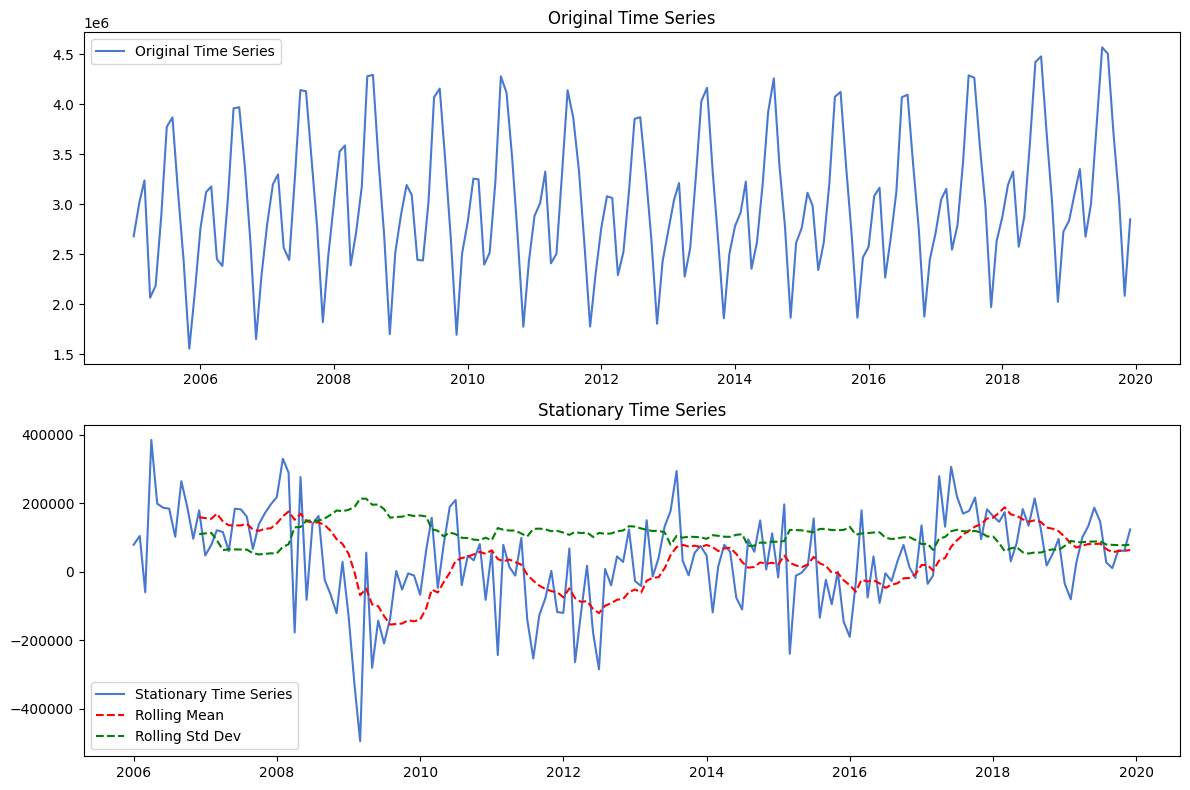

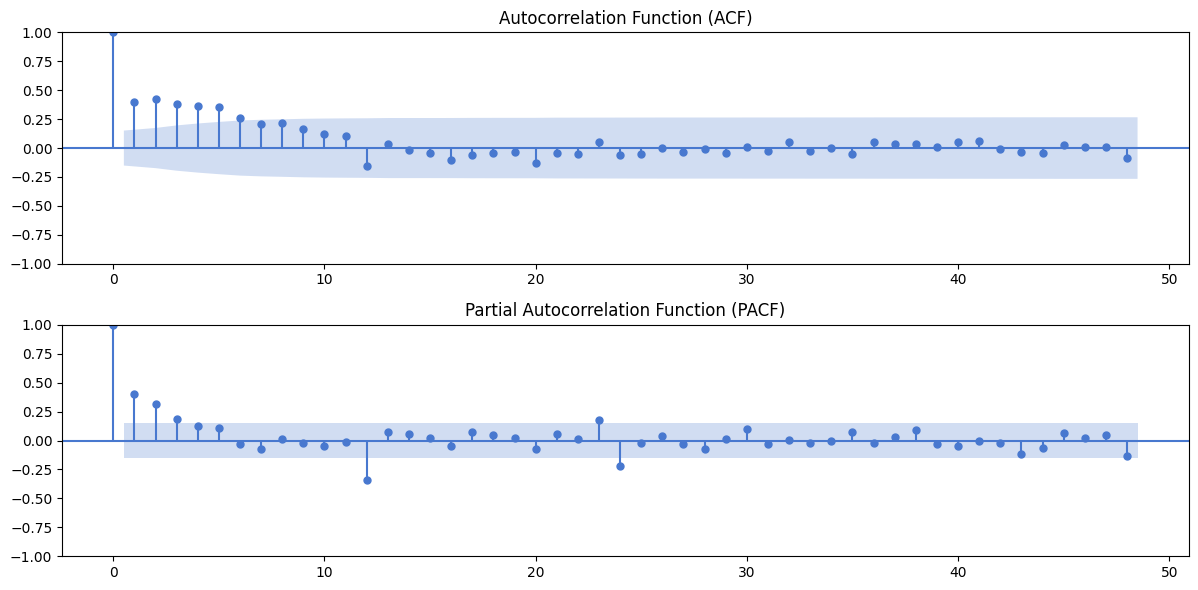

In [17]:
# Plot the original and stationary time series
plt.figure(figsize=(12, 8))

# Plot for original time series
plt.subplot(2, 1, 1)
plt.plot(all_data_sans_covid.index, ons, label='Original Time Series')
plt.title('Original Time Series')
plt.legend()

# Calculate rolling statistics for stationary time series
window_size = 12
rolling_mean = ons_SA.rolling(window=window_size).mean()
rolling_std = ons_SA.rolling(window=window_size).std()

# Plot for stationary time series
plt.subplot(2, 1, 2)
plt.plot(ons_SA.index, ons_SA, label='Stationary Time Series')
plt.plot(rolling_mean, label='Rolling Mean', color='red', linestyle='--')
plt.plot(rolling_std, label='Rolling Std Dev', color='green', linestyle='--')
plt.title('Stationary Time Series')
plt.legend()

plt.tight_layout()
plt.show()

# Plot ACF and PACF in a separate figure
plt.figure(figsize=(12, 6))

# ACF plot
plt.subplot(2, 1, 1)
plot_acf(ons_SA.dropna(), lags=48, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

# PACF plot
plt.subplot(2, 1, 2)
plot_pacf(ons_SA.dropna(), lags=48, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

# Modelling  
  
In the following section all the models are trained and evaluated on the data.

### Dataset Preparation  
  
To store the results, we initialized a list 'results_mse' to store the mse's from the different models.  
  
The seasonally adjusted overnight stays (ons_SA) will be shifted by one row forward so we train our observations on future datapoints:
  
| Time     | ons_SA | ons_SA_shifted | Features |
|----------|-----------------------|----------------------|----------|
| 2005-01  | 1000                  | NaN                  | 0.23     |
| 2005-02  | 1100                  | 1000                 | 0.45     |
| 2005-03  | 1200                  | 1100                 | 0.67     |
| 2005-04  | 1300                  | 1200                 | 0.89     |
| 2005-05  | 1400                  | 1300                 | 0.12     |
| ...      | ...                   | ...                  | ...      |
  
The rows that contain NaN's will be dropped.  
To improve our predictions further we added lags of the target values, as the past development of the amount of overnight stays is also available at these points of observations.

In [18]:
# initialize list for results of mse
results_mse = []

# shift the labels one row back so we train the model to predict the next month
ons_SA_shifted = ons_SA.shift(-1) # future values
ons_SA_shifted.dropna(inplace=True)

# define the dependent and independent variables
y = ons_SA_shifted
X = all_data_sans_covid.drop(['Total_overnight_stays'], axis=1)

# add lags with past values of the target variable
X['lag0'] = ons_SA
X['lag1'] = ons_SA.shift(1)
X['lag2'] = ons_SA.shift(2)
X['lag3'] = ons_SA.shift(3)
X['lag4'] = ons_SA.shift(4)
X['lag5'] = ons_SA.shift(5)
X['lag6'] = ons_SA.shift(6)
X['lag7'] = ons_SA.shift(7)
X['lag8'] = ons_SA.shift(8)
X['lag9'] = ons_SA.shift(9)
X['lag10'] = ons_SA.shift(10)
X['lag11'] = ons_SA.shift(11)
X.dropna(inplace=True)

# add a constant
X = sm.add_constant(X)

# drop the rows that are not present in both datasets
X = X.loc[X.index.isin(y.index)]
y = y.loc[y.index.isin(X.index)]

In [19]:
# make sure there are no missing values
print(X.isna().sum().sum())
print(y.isna().sum().sum())

0
0


In [20]:
# train test split, year 2019 is the test set
X_train, X_test, y_train, y_test = X[:-24], X[-24:], y[:-24], y[-24:]

# scale the data for models that perform better with scaled data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [21]:
features = np.ones(len(y)-36)

model = LinearRegression()
model.fit(features.reshape(-1, 1), y[:-36])

model.intercept_

5701.25

In [22]:
# Calculate the MSE for the naive model (benchmark for other models)
true_values = y[-36:].values
preds = np.ones(len(true_values))*5701.25 # best intercept of OLS whith a constant of 1 as feature

mse = mean_squared_error(true_values, preds)
print(f'MSE: {mse:.2e}')

MSE: 1.90e+10


## Polynomial Regression

**Feature Selection**  
  
The simple Regressions without Ridge & Lasso performed poorly with the whole dataset (worse than the naive model) due to extreme overfitting. To improve this we tried feature selection what improved the predictions by a factor of 10. First we tried the feature selection tool from scikit-learn. When thinking about which features should have the highest impact we tried out a few of these and it turned out that this works better than the scikit learn selection.

In [23]:
# Compute the correlation matrix for feature selection
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(110, 90))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [24]:
# Feature selection tool from sklearn
# Create a Linear Regression model
model = LinearRegression()

# Initialize RFE
rfe = RFE(model, n_features_to_select=3) # selects 3 features

# Fit RFE
rfe = rfe.fit(X, y)

# Print the boolean results
feature_mask_linreg = rfe.support_

features_columns = X.columns[feature_mask_linreg]

In [25]:
# feature selection for the polynomial regression model
Xfs_train = X[['CH: Unemployment Rate', 'SNB: REER', 'CH:  RGDP Growth', 'lag11', 'lag0']][:-36] #
Xfs_test = X[['CH: Unemployment Rate', 'SNB: REER', 'CH:  RGDP Growth', 'lag11', 'lag0']][-36:] #

Xfs_train_scaled = scaler.fit_transform(Xfs_train)
Xfs_test_scaled = scaler.transform(Xfs_test)

In [26]:
# Create a Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
preds = model.predict(X_test)

# cross validation
tscv = TimeSeriesSplit(n_splits=5)
cv_score = cross_val_score(model, X_train, y_train, 
                           cv=tscv, scoring="neg_mean_squared_error")

# Calculate the MSE's
cv_score_average = -np.mean(cv_score)
mse = mean_squared_error(y_test, preds)

# Print the results
print(f"Empirical risk scikit linreg:   {mse:.2e}")
print(f"CV score scikit linreg:         {cv_score_average:.2e}")

# Append the results to the list of MSE results
results_mse.append(('Regression degree 1 (feature selection)', mse))

# print the coefficients
print(model.coef_)
print(model.intercept_)

Empirical risk scikit linreg:   3.26e+11
CV score scikit linreg:         1.15e+13
[ 3.40875602e+00  3.75377326e+03 -1.03898260e+04  2.90271281e+02
 -1.24421469e+04 -4.25410784e+03  7.88844381e+01  2.34012765e+03
 -1.07930212e+04  7.45850181e+03  2.30917289e+03  5.18203334e+03
 -1.04648810e+04  1.51538228e+04 -1.50432828e+04  3.85326237e+03
  1.74376221e+04  9.01327516e+03  4.43513248e+03  1.66637414e+03
  1.11737143e+04  5.43348244e+03 -7.15842099e+03  3.29440761e+03
 -9.36658328e+03 -1.29903761e+04 -5.71478965e+03  3.91528267e+02
 -4.16018422e+03 -7.70273370e+02  7.04013308e+03 -1.03375192e+04
 -4.46261961e+03  1.60672570e+03  1.47565384e+02  6.48136262e+03
 -1.78336829e+03 -1.56369840e+04  6.80312949e+03 -9.88875250e+03
  4.05323431e+04 -1.05588965e+04 -1.29575696e+04  1.01369396e+04
 -2.58308226e+02 -1.24385110e+04 -9.86120040e+03  1.00662641e+04
  4.44321249e+03 -1.85609706e+04  4.24627185e+04  4.38547691e+03
  7.85372145e+03 -1.66937110e+04  8.17310350e+03  4.38564334e+03
 -6.5107

In [27]:
# polynomial regression degree 2
degree = 2

# use pipeline to make code shorter
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# cross validation
tscv = TimeSeriesSplit(n_splits=5) 
scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring='neg_mean_squared_error')
cv_scores = -scores

# Calculate the MSE's
average_cv = cv_scores.mean()
mse = mean_squared_error(y_test, y_pred)

# Print the results and append them to the list of MSE results
print(f'Empirical risk polynomial regression scikit degree 2:   {mse:.2e}')
print(f"CV score polynomial reg 2:                              {average_cv:.2e}")

results_mse.append(('Regression degree 2 (feature selection, standardization)', mse))

Empirical risk polynomial regression scikit degree 2:   1.32e+10
CV score polynomial reg 2:                              3.32e+10


In [28]:
# polynomial regression degree 3
degree = 3

model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# cross validation
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring='neg_mean_squared_error')
cv_scores = -scores

# Calculate the MSE's
average_cv = cv_scores.mean()
mse = mean_squared_error(y_test, y_pred)

# Print the results and append them to the list of MSE results
print(f'Empirical risk polynomial regression scikit degree 3:   {mse:.2e}')
print(f"CV score polynomial reg 3:                              {average_cv:.2e}")

results_mse.append(('Regression degree 3 (standardization)', mse))

Empirical risk polynomial regression scikit degree 3:   1.66e+10
CV score polynomial reg 3:                              1.93e+10


In [29]:
# polynomial regression degree 4
#degree = 4

#model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
#model.fit(X_train_scaled, y_train)
#y_pred = model.predict(X_test_scaled)

# cross validation
#tscv = TimeSeriesSplit(n_splits=5)
#scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
#cv_scores = -scores

# Calculate the MSE's
#average_cv = cv_scores.mean()
#mse = mean_squared_error(y_test, y_pred)

# Print the results and append them to the list of MSE results
#print(f'Empirical risk polynomial regression scikit degree 4:   {mse:.2e}')
#print(f"CV score polynomial reg 4:                              {average_cv:.2e}")

#results_mse.append(('scikit polynomial reg 4', mse))


## Autoregressive models

In [30]:
# autoregressive model ARIMA
results = pd.DataFrame(np.zeros((8, 1)))

training = ons[:-12] # labels including 2018
training.index.freq = 'MS'
testing = ons[-12:] # labels of 2019

# loop over different p values
for p in range(5, 16):
    mod = sm.tsa.ARIMA(training, order=(p, 3, 0))  # d of 3 is minimum so algorithm works
    res = mod.fit()
    forecast = res.forecast(steps=12, signal_only=False)
    # Store the mean squared error for each combination of p and q
    results.loc[p] = ((testing.values - forecast.values) ** 2).mean()


results_mse.append(('ARIMA min (5-16, 3, 0)', results[0].min()))

C:\Users\raffa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\raffa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\raffa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\raffa\AppData\Local\Packages

In [31]:
# autoregressive model ARIMA with log transformation
results = pd.DataFrame(np.zeros((8, 1)))

# Apply log transformation
training_log = np.log(training)
testing_log = np.log(testing)

for p in range(5, 16):
    mod = sm.tsa.ARIMA(training_log, order=(p, 3, 0))  # Adjust 'd' parameter if necessary
    res = mod.fit()
    forecast = res.forecast(steps=12, signal_only=False)
    # Store the mean squared error for each combination of p and q
    results.loc[p] = ((testing_log.values - forecast.values) ** 2).mean()

results_mse.append(('ARIMA log min (5-16, 3, 0)', results[0].min()))

C:\Users\raffa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\raffa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\raffa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\raffa\AppData\Local\Packages

In [32]:
# rolling window
result = []

for iter in range(1, 8): #for every year not enough parameters to start
    start = 12*2*iter-12*2
    lim = 12*2*iter
    lim_up = lim + 12
    training = ons[start:lim]
    testing = ons[lim:lim_up]

    mod = sm.tsa.ARIMA(training, order=(24, 3, 1))
    res = mod.fit()
    forecast = res.forecast(steps=12, signal_only=False)
    # Store the mean squared error
    result.append(((testing.values - forecast.values) ** 2).mean())

average_mse = sum(result) / len(result) # average mean squared error of cross validation
results_mse.append(('ARIMA cv (24, 3, 1)', average_mse))

C:\Users\raffa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\raffa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\raffa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\raffa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Local

In [33]:
#expanding window
result = []

for iter in range(1, 8): #for every year not enough parameters to start
    lim = 12*2*iter
    lim_up = lim + 12
    training = ons[:lim]
    testing = ons[lim:lim_up]

    mod = sm.tsa.ARIMA(training, order=(14, 3, 0))
    res = mod.fit()
    forecast = res.forecast(steps=12, signal_only=False)
    # Store the mean squared error
    result.append(((testing.values - forecast.values) ** 2).mean())
    
average_mse = sum(result) / len(result) # average mean squared error
results_mse.append(('ARIMA cv (14, 3, 0)', average_mse))

C:\Users\raffa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\raffa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\raffa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\raffa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Local

In [34]:
# auto arima to compare to our parameter selection

training = ons_SA[:-12] # labels including 2018
training.dropna(inplace=True)
training.index.freq = 'MS'
testing = ons_SA[-12:] # labels of 2019

# Fit auto_arima function to data
model = auto_arima(training, seasonal=False)

# Fit the model to the training data
model.fit(training)

# Make predictions for the next 12 steps
forecast = model.predict(n_periods=12)

# Calculate the mean squared error
mse = ((testing.values - forecast) ** 2).mean()

# Print results and append to results_mse
print(f'Empirical risk auto ARIMA: {mse:.2e}')

results_mse.append(('Auto ARIMA', mse))

Empirical risk auto ARIMA: 9.90e+09


13:33:21 - cmdstanpy - INFO - Chain [1] start processing
13:33:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\raffa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\raffa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), 

Mean Squared Error (MSE): 3.85e+10


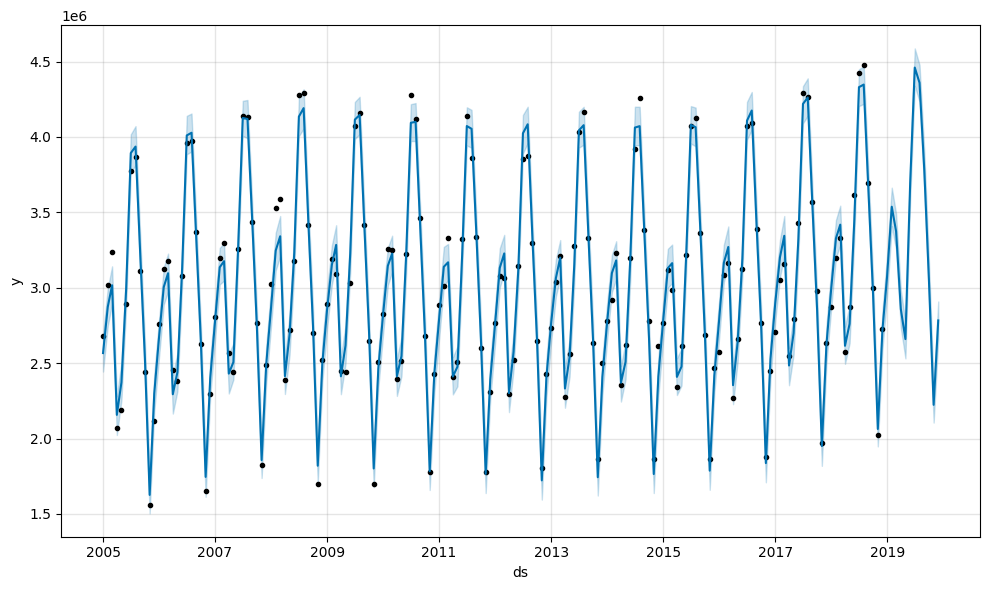

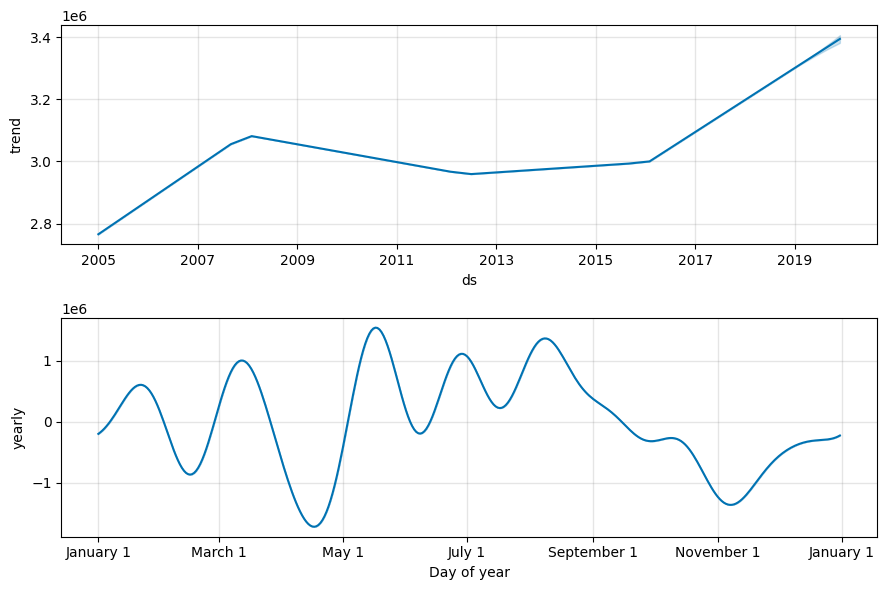

In [35]:
# Facebook Prophet autoregressive model
# Create a new DataFrame with specs for Prophet
ons_df_prophet1 = pd.DataFrame(ons)
ons_df_prophet1.dropna(inplace=True)
ons_df_prophet1.reset_index(inplace=True)
ons_df_prophet = ons_df_prophet1.rename(columns={'date': 'ds', 'Total_overnight_stays': 'y'})
ons_df_prophet['ds'] = pd.to_datetime(ons_df_prophet['ds'])

# Training data
training = ons_df_prophet[:-12].copy()  # Copy to avoid modifying the original DataFrame

# Testing data
testing = ons_df_prophet[-12:].copy()  # Copy to avoid modifying the original DataFrame

# Fit the model
model = Prophet()
model.fit(training)

# Make future dataframe
future = model.make_future_dataframe(periods=12, freq='M')

# Make predictions
forecast = model.predict(future)

fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

y_true = testing['y'].values
y_pred = forecast['yhat'][-len(testing):].values
mse = mean_squared_error(y_true, y_pred)

# Print results and append to results_mse
print(f'Mean Squared Error (MSE): {mse:.2e}')

results_mse.append(('Facebook Prophet', mse))

## Regression (Ridge & Lasso)

In [36]:
# variable z for comparison
z = all_data_sans_covid["Total_overnight_stays"]

In [38]:
%%time

# Initialize StandardScaler
scaler = StandardScaler()

best_params_lasso = {'window_size': None, 'tol': None, 'alpha': None, 'best_mse': float('inf')}

# Loop over different window sizes
for window_size_lasso in range(42,44):
    # Loop over different tolerance values
    for tol_value_lasso in [1e-2, 1e-1, 1, 1e1]:
        # Loop over different alpha values
        for alpha_value_lasso in [1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]:
            mse_values_lasso = []
            all_y_true_lasso = []
            all_y_pred_lasso = []

            # Perform rolling window cross-validation
            for i in range(len(X) - window_size_lasso + 1):
                train_index = range(i, i + window_size_lasso)
                test_index = i + window_size_lasso

                X_train_rl, X_test_rl = X.iloc[train_index], X.iloc[test_index:test_index+1]
                y_train_rl, y_test_rl = y.iloc[train_index], y.iloc[test_index:test_index+1]

                if len(X_train_rl) > 0 and len(X_test_rl) > 0:
                    # Standardize the features using the mean and standard deviation from the training set
                    X_train_rl_scaled = scaler.fit_transform(X_train_rl.values)
                    X_test_rl_scaled = scaler.transform(X_test_rl.values)

                    # Train the Lasso model
                    lasso_model = Lasso(tol=tol_value_lasso, alpha=alpha_value_lasso, max_iter=1000000)

                    # Fit the Lasso model
                    lasso_model.fit(X_train_rl_scaled, y_train_rl)

                    # Evaluate the model using Mean Squared Error
                    predictions_lasso = lasso_model.predict(X_test_rl_scaled)
                    mse_lasso = mean_squared_error(y_test_rl, predictions_lasso)
                    mse_values_lasso.append(mse_lasso)

                    all_y_true_lasso.extend(y_test_rl.values)
                    all_y_pred_lasso.extend(predictions_lasso)

            # Calculate the average MSE over all folds
            average_mse_lasso = np.mean(mse_values_lasso)

            # Check if this combination is the best so far
            if average_mse_lasso < best_params_lasso['best_mse']:
                best_params_lasso['window_size'] = window_size_lasso
                best_params_lasso['tol'] = tol_value_lasso
                best_params_lasso['alpha'] = alpha_value_lasso
                best_params_lasso['best_mse'] = average_mse_lasso

# Create DataFrame for results for Lasso
results_df_lasso = pd.DataFrame({'y_true': all_y_true_lasso, 'y_pred': all_y_pred_lasso, 'true': z.tail(len(all_y_true_lasso))})

# Print the best parameters and corresponding MSE
print(f'Best Parameters Lasso: {best_params_lasso}')
print(f'Best Mean Squared Error: {best_params_lasso["best_mse"]:.4e}')

# Append the results to the list of MSE results
results_mse.append(('Lasso Regression', best_params_lasso["best_mse"]))

Best Parameters Lasso: {'window_size': 43, 'tol': 0.01, 'alpha': 100000.0, 'best_mse': 13010514762.797722}
Best Mean Squared Error: 1.3011e+10
CPU times: total: 12 s
Wall time: 43.3 s


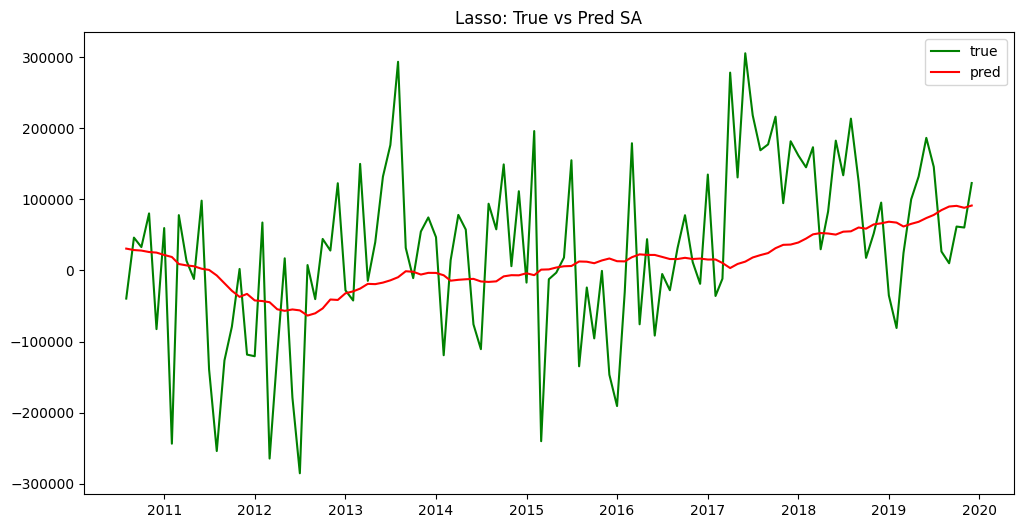

In [39]:
#plot results
plt.figure(figsize=(12, 6))
plt.plot(results_df_lasso["y_true"], label='true', color="green")
plt.plot(results_df_lasso["y_pred"], label='pred', color="red")
plt.title('Lasso: True vs Pred SA')
plt.legend()

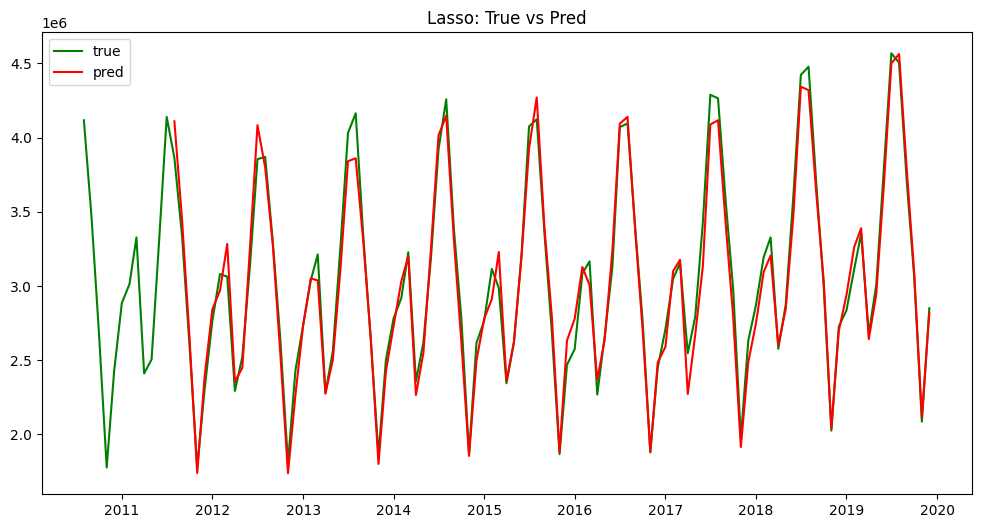

In [40]:
# merge results with actual values
ons_df = pd.DataFrame({'ons': ons})
results_df_lasso_ons = pd.merge(results_df_lasso, ons_df, left_index=True, right_index=True)

# Reverse seasonally-adjusting
pred = results_df_lasso_ons["y_pred"] + results_df_lasso_ons["ons"].shift(12)
results_df_lasso_ons["pred"] = pred

#plot results
plt.figure(figsize=(12, 6))
plt.plot(results_df_lasso_ons["true"], label='true', color="green")
plt.plot(results_df_lasso_ons["pred"], label='pred', color="red")
plt.title('Lasso: True vs Pred')
plt.legend()

In [41]:
%%time

# Initialize StandardScaler
scaler = StandardScaler()

best_params_ridge = {'window_size': None, 'tol': None, 'alpha': None, 'best_mse': float('inf')}

# Loop over different window sizes
for window_size_ridge in range(48, 52):
    # Loop over different tolerance values
    for tol_value_ridge in [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]:
        # Loop over different alpha values
        for alpha_value_ridge in [1e3, 1e4, 1e5]:
            mse_values_ridge = []
            all_y_true_ridge = []
            all_y_pred_ridge = []

            # Perform rolling window cross-validation
            for i in range(len(X) - window_size_ridge + 1):
                train_index = range(i, i + window_size_ridge)
                test_index = i + window_size_ridge

                X_train_rl, X_test_rl = X.iloc[train_index], X.iloc[test_index:test_index+1]
                y_train_rl, y_test_rl = y.iloc[train_index], y.iloc[test_index:test_index+1]

                if len(X_train_rl) > 0 and len(X_test_rl) > 0:
                    # Standardize the features using the mean and standard deviation from the training set
                    X_train_rl_scaled = scaler.fit_transform(X_train_rl.values)
                    X_test_rl_scaled = scaler.transform(X_test_rl.values)

                    # Train the Ridge model
                    ridge_model = Ridge(tol=tol_value_ridge, alpha=alpha_value_ridge, max_iter=1000000)
                    ridge_model.fit(X_train_rl_scaled, y_train_rl)

                    # Evaluate the model using Mean Squared Error
                    predictions_ridge = ridge_model.predict(X_test_rl_scaled)
                    mse_ridge = mean_squared_error(y_test_rl, predictions_ridge)
                    mse_values_ridge.append(mse_ridge)

                    all_y_true_ridge.extend(y_test_rl.values)
                    all_y_pred_ridge.extend(predictions_ridge)

            # Calculate the average MSE over all folds
            average_mse_ridge = np.mean(mse_values_ridge)

            # Check if this combination is the best so far
            if average_mse_ridge < best_params_ridge['best_mse']:
                best_params_ridge['window_size'] = window_size_ridge
                best_params_ridge['tol'] = tol_value_ridge
                best_params_ridge['alpha'] = alpha_value_ridge
                best_params_ridge['best_mse'] = average_mse_ridge

# Create DataFrame for results for Ridge
results_df_ridge = pd.DataFrame({'y_true': all_y_true_ridge, 'y_pred': all_y_pred_ridge, 'true': z.tail(len(all_y_true_ridge))})

# Print the best parameters and corresponding MSE
print(f'Best Parameters Ridge: {best_params_ridge}')
print(f'Best Mean Squared Error: {best_params_ridge["best_mse"]:.4e}')

# Append the results to the list of MSE results
results_mse.append(('Ridge Regression', best_params_ridge["best_mse"]))

Best Parameters Ridge: {'window_size': 50, 'tol': 1e-10, 'alpha': 1000.0, 'best_mse': 11356577543.60881}
Best Mean Squared Error: 1.1357e+10
CPU times: total: 8.97 s
Wall time: 35.6 s


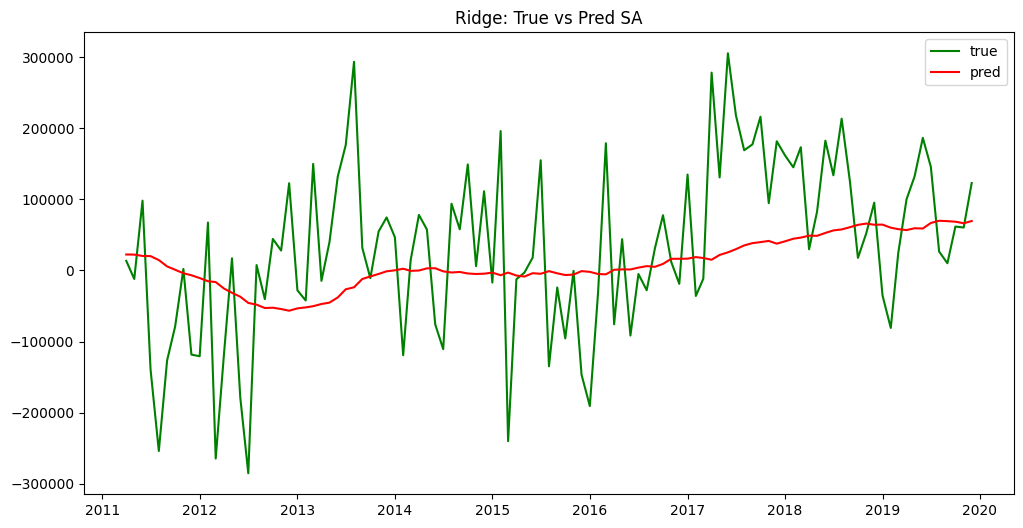

In [42]:
#plot results
plt.figure(figsize=(12, 6))
plt.plot(results_df_ridge["y_true"], label='true', color="green")
plt.plot(results_df_ridge["y_pred"], label='pred', color="red")
plt.title('Ridge: True vs Pred SA')
plt.legend()

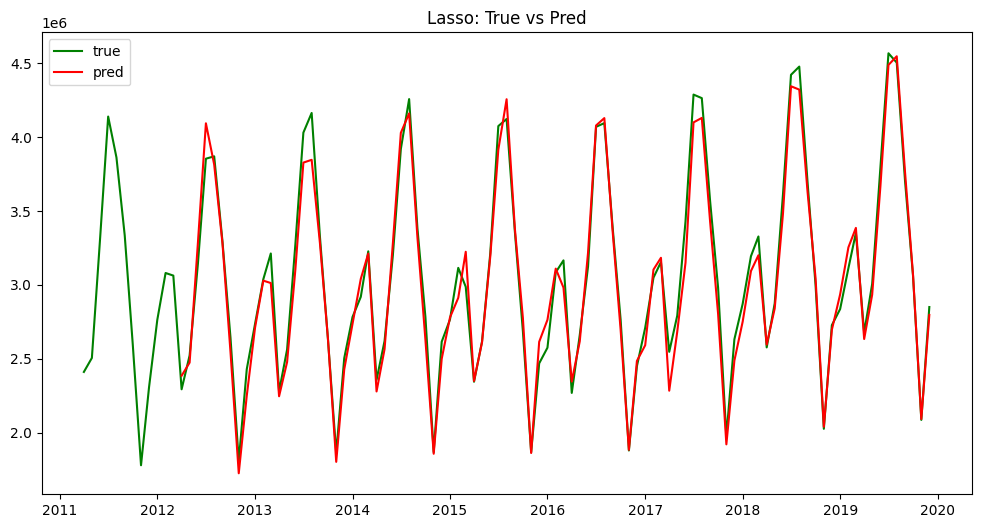

In [43]:
# merge results with actual values
ons_df = pd.DataFrame({'ons': ons})
results_df_ridge_ons = pd.merge(results_df_ridge, ons_df, left_index=True, right_index=True)

# Reverse seasonally-adjusting
pred = results_df_ridge_ons["y_pred"] + results_df_ridge_ons["ons"].shift(12)
results_df_ridge_ons["pred"] = pred

#plot results
plt.figure(figsize=(12, 6))
plt.plot(results_df_ridge_ons["true"], label='true', color="green")
plt.plot(results_df_ridge_ons["pred"], label='pred', color="red")
plt.title('Lasso: True vs Pred')
plt.legend()

In [44]:
print(f'Average Mean Squared Error Lasso: {best_params_lasso["best_mse"]:.4e}')
print(f'Average Mean Squared Error Ridge: {best_params_ridge["best_mse"]:.4e}')

Average Mean Squared Error Lasso: 1.3011e+10
Average Mean Squared Error Ridge: 1.1357e+10


## Neural Network

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split

# Definieren der Hyperparameter und ihrer Bereiche
parameter_space = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.01],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [1000]
}

# Definieren Sie Ihren MLPRegressor
mlp = MLPRegressor()

# Erstellen Sie den GridSearchCV-Objekt mit weniger Folds
grid_search = GridSearchCV(estimator=mlp, param_grid=parameter_space, n_jobs=-1, cv=3, scoring=make_scorer(mean_squared_error, greater_is_better=False))

# Skalieren Sie Ihre Daten
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Führen Sie die Suche aus
grid_search.fit(X_train_scaled, y_train)

# Die besten Hyperparameter ausgeben
print('Best parameters found:\n', grid_search.best_params_)

# Die beste Modellinstanz erhalten
best_mlp = grid_search.best_estimator_

# Vergessen Sie nicht, die Testdaten ebenfalls zu skalieren
X_test_scaled = scaler.transform(X_test)
y_pred_test = best_mlp.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_pred_test)
print(f'Test MSE: {test_mse}')

# Append the results to the list of MSE results
results_mse.append(('MLP Regressor', test_mse))


C:\Users\raffa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
24 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\raffa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\raffa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-pack

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01, 'max_iter': 1000, 'solver': 'adam'}
Test MSE: 12928094503.962729


C:\Users\raffa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [47]:
# Import the multilayer perceptron regressor from sklearn
from sklearn.neural_network import MLPRegressor
# Import a helper to scale our data
from sklearn.preprocessing import StandardScaler


nnet = MLPRegressor(hidden_layer_sizes=(75,), activation="relu", solver="adam",
                    alpha=0.0001, learning_rate_init=0.01, batch_size=32, max_iter=1000)
#X_train, y_train
#X_test, y_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scale the outputs (we cannot use StandardScaler() on a 1D array)
mu  , sigma = y_train.mean(), y_train.std() # We will use this to scale back to original values!
y_train_scaled = (y_train - mu) / sigma

# Fit the network on train data
nnet.fit(X_train_scaled, y_train_scaled)

# Make predictions
ypred_nnet_train = nnet.predict(X_train_scaled)
ypred_nnet_test = nnet.predict(X_test_scaled)

# Reconstruct outputs and scale predictions
ypred_nnet_train = ypred_nnet_train * sigma + mu
ypred_nnet_test = ypred_nnet_test * sigma + mu

# Compute the MAE for the train set
mae_nnet = np.sum(np.abs(ypred_nnet_train - y_train))
print(f"Train set: The mean absolute error is {mae_nnet}")
# Compute the MSE for the train set
mse_nnet = mean_squared_error(y_train, ypred_nnet_train)
print(f'Train set: The mean squared error is {mse_nnet}')


# Compute the MAE for the TEST SET
mae_nnet = np.sum(np.abs(ypred_nnet_test - y_test))
print(f"Test set: The mean absolute error is {mae_nnet}")
# Compute the MSE for the TEST SET
mse_nnet = mean_squared_error(y_test, ypred_nnet_test)
print(f'Test set: The mean squared error is {mse_nnet}')


# Create DataFrame for results
results_nnet = pd.DataFrame({'y_test': y_test, 'y_pred_test': ypred_nnet_test})

# Append the results to the list of MSE results
results_mse.append(('Neural Network', mse_nnet))

Train set: The mean absolute error is 4142357.31970443
Train set: The mean squared error is 2045287449.816879
Test set: The mean absolute error is 2095256.5379998859
Test set: The mean squared error is 10763026544.421822


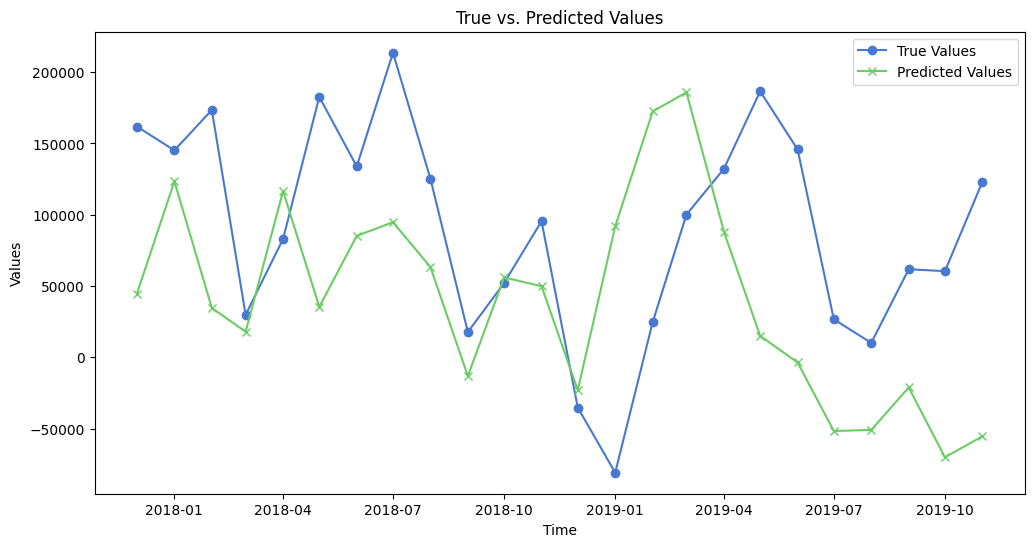

In [48]:
# Plotting true vs. predicted values in nnet
plt.figure(figsize=(12, 6))
plt.plot(results_nnet['y_test'], label='True Values', marker='o')
plt.plot(results_nnet['y_pred_test'], label='Predicted Values', marker='x')
plt.title('True vs. Predicted Values')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

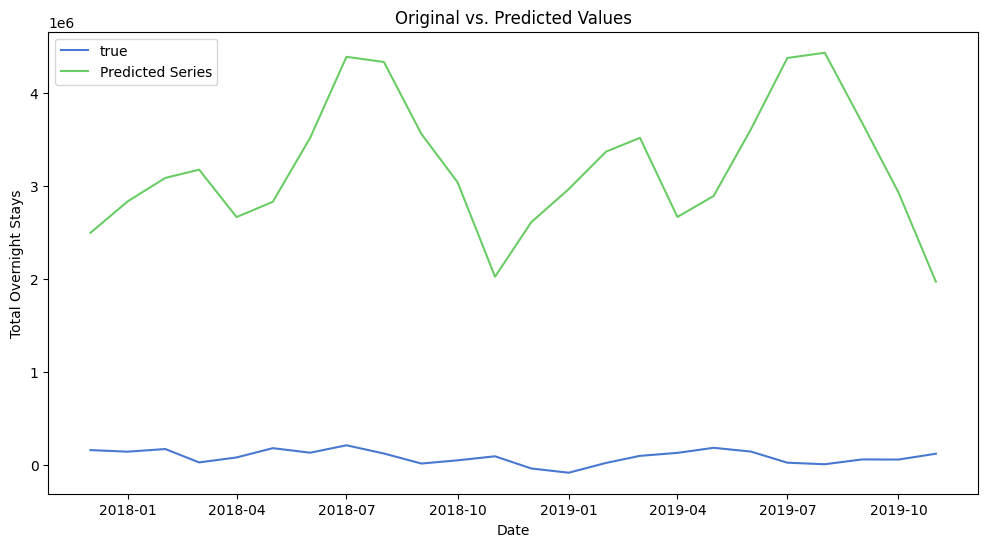

In [49]:
pred_nnet = results_nnet["y_pred_test"]

# Reverse seasonally-adjusting
pred_nnet_final = pred_nnet + ons.shift(12)

results_nnet["pred final"] = pred_nnet_final

# Plotting the original vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(results_nnet["y_test"], label ="true")
plt.plot(results_nnet["pred final"], label ="Predicted Series")
plt.title("Original vs. Predicted Values")
plt.xlabel("Date")
plt.ylabel("Total Overnight Stays")
plt.legend()
plt.show()

## Random Forest

In [50]:
# Initialize constant
best_mse_constant = 1e11

#Find the best constant
for constant in range(-60000,60000):
    preds = np.ones(len(y))*constant
    mse_constant = mean_squared_error(y, preds)
    average_mse_constant = np.mean(mse_constant)
    if average_mse_constant < best_mse_constant:
        best_constant = constant
        best_mse_constant = average_mse_constant

#Add constant to X
X["constant"] = best_constant

print(f'Average Mean Squared Error Constant: {best_constant}')
print(f'Average Mean Squared Error Constant: {average_mse_constant:.4e}')

# Append the results to the list of MSE results
results_mse.append(('Constant', average_mse_constant))

Average Mean Squared Error Constant: 30215
Average Mean Squared Error Constant: 1.9315e+10


Best Parameters: Window Size = 25, n_estimators = 51
Best MSE: 1.223723e+10


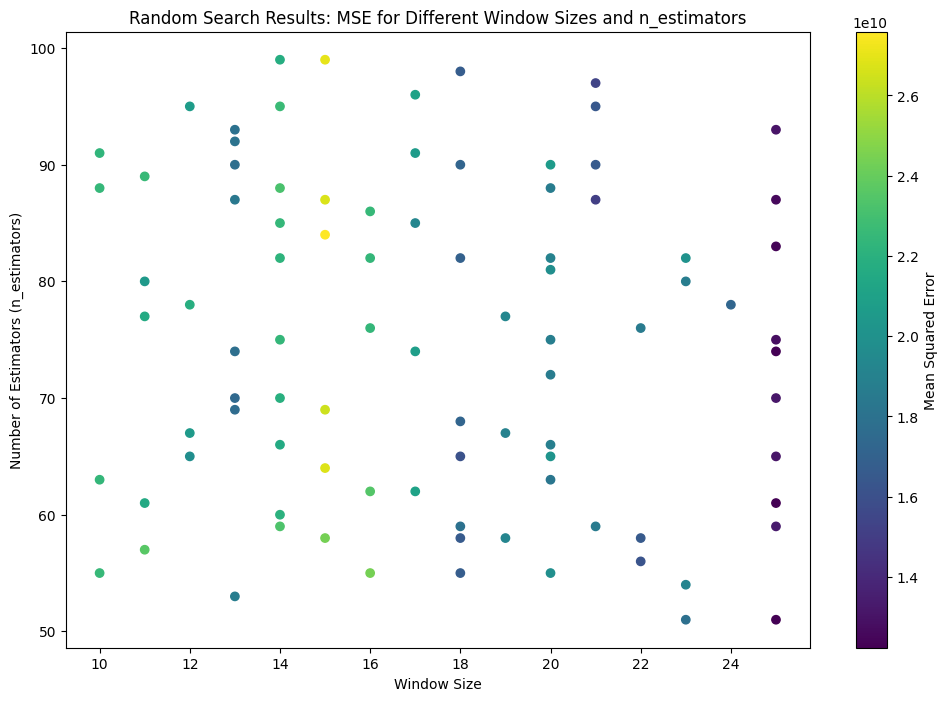

In [51]:
#Find the best window size and an enough large n_estimator for the Rolling Window Approach with RandomSearch
import random

# Initialize StandardScaler
scaler = StandardScaler()

# Define the range for window sizes and n_estimators
window_size_range = range(10, len(X) // 6)
n_estimators_range = range(50, 100)  

# Number of iterations for random search
n_iterations = 100

# Initialize dictionary to store results
results_dict = {}

# Random Search
for _ in range(n_iterations):
    # Randomly select window_size and n_estimators
    window_size = random.choice(window_size_range)
    n_estimators = random.choice(n_estimators_range)

    # Initialize lists to store results for this configuration
    mse_values = []
    all_y_true = []
    all_y_pred = []

    # Define the number of windows
    num_windows = len(X) // window_size

    # Perform stationary window
    for i in range(num_windows):
        # Define train and test sets
        start_train = i * window_size
        end_train = start_train + window_size
        start_test = end_train
        end_test = start_test + window_size

        X_train, X_test = X.iloc[start_train:end_train], X.iloc[start_test:end_test]
        y_train, y_test = y.iloc[start_train:end_train], y.iloc[start_test:end_test]

        if not X_test.empty and not y_test.empty:
            # Scale the data
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # Train the Random Forest model
            rf_model = RandomForestRegressor(n_estimators=n_estimators, bootstrap = True)
            rf_model.fit(X_train_scaled, y_train)

            # Predict and evaluate
            predictions = rf_model.predict(X_test_scaled)
            mse = mean_squared_error(y_test, predictions)
            mse_values.append(mse)
            all_y_true.extend(y_test)
            all_y_pred.extend(predictions)

    # Store the results
    average_mse = np.mean(mse_values)
    results_dict[(window_size, n_estimators)] = average_mse

# Find the best parameters
best_parameters = min(results_dict, key=results_dict.get)
best_mse = results_dict[best_parameters]

print(f"Best Parameters: Window Size = {best_parameters[0]}, n_estimators = {best_parameters[1]}")
print(f"Best MSE: {best_mse:2e}")

# Extracting window sizes, n_estimators, and MSEs from the results dictionary
window_sizes = [key[0] for key in results_dict.keys()]
n_est_values = [key[1] for key in results_dict.keys()]
mses = [value for value in results_dict.values()]

# Creating the scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(window_sizes, n_est_values, c=mses, cmap='viridis')
plt.colorbar(scatter, label='Mean Squared Error')
plt.xlabel('Window Size')
plt.ylabel('Number of Estimators (n_estimators)')
plt.title('Random Search Results: MSE for Different Window Sizes and n_estimators')
plt.show()

Average Mean Squared Error: 2.66e+10


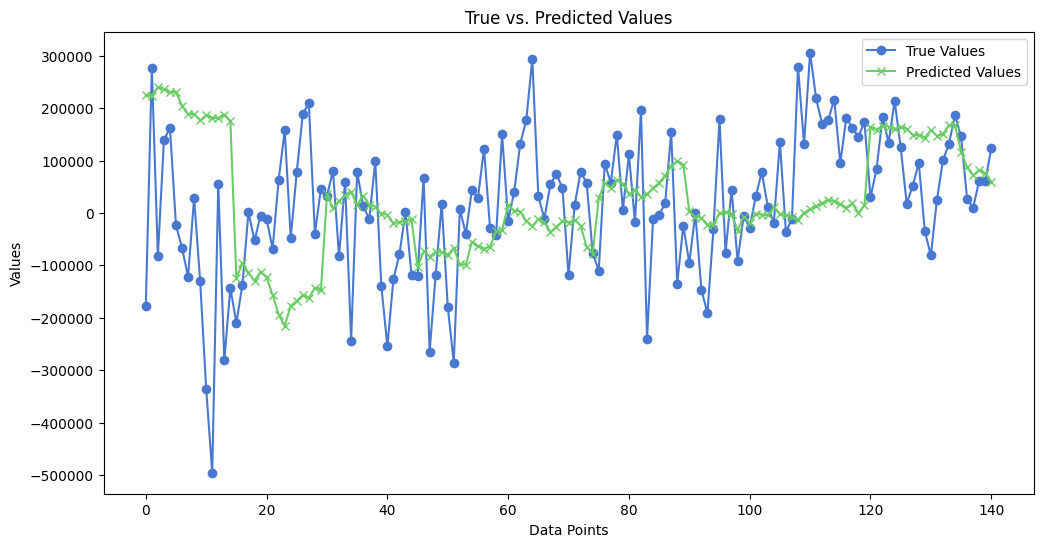

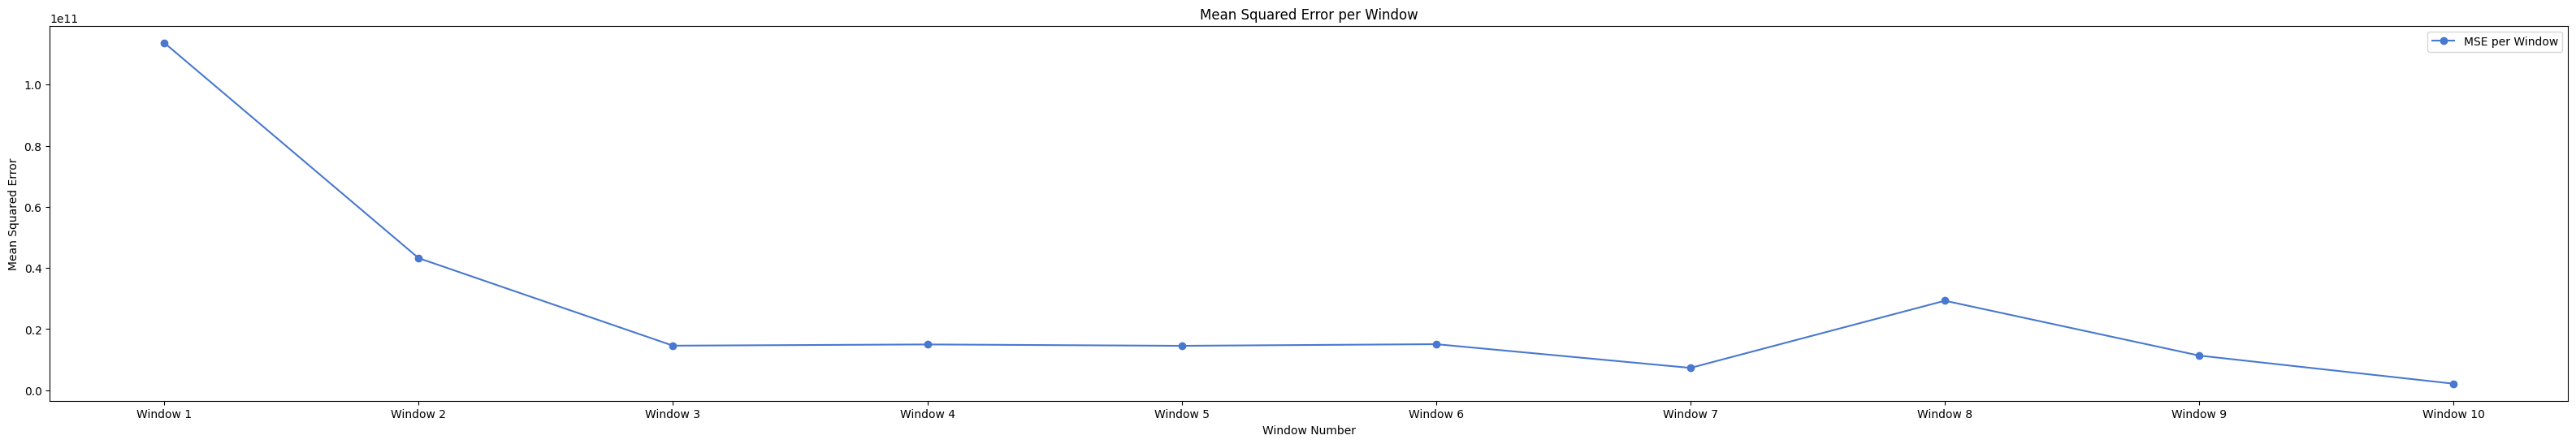

In [52]:
#Perform the Rolling Window Approach with the best paramaters

#Initialize StandardScaler
scaler = StandardScaler()

# Initialize lists to store results
mse_values = []
all_y_true = []
all_y_pred = []

# Define the rolling window parameters
window_size = len(X) // 10
test_size = window_size    

# Perform rolling window
for i in range(0, len(X) - window_size, test_size):
    start_train = i
    end_train = start_train + window_size

    # Define the start and end of the test set
    start_test = end_train
    end_test = start_test + test_size

    # Split the data
    X_train, X_test = X.iloc[start_train:end_train], X.iloc[start_test:end_test]
    y_train, y_test = y.iloc[start_train:end_train], y.iloc[start_test:end_test]

    # Standardize the features using the mean and standard deviation from the training set
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=88, bootstrap = True, max_depth = 5 )
    rf_model.fit(X_train_scaled, y_train)

    # Evaluate the model using Mean Squared Error
    predictions = rf_model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, predictions)
    mse_values.append(mse)
    all_y_true.extend(y_test.values)
    all_y_pred.extend(predictions)


# Calculate the average MSE over all windows
average_mse = np.mean(mse_values)
print(f'Average Mean Squared Error: {average_mse:.2e}')

# Plotting true vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(all_y_true, label="True Values", marker='o')
plt.plot(all_y_pred, label="Predicted Values", marker='x')
plt.title("True vs. Predicted Values")
plt.xlabel("Data Points")
plt.ylabel("Values")
plt.legend()
plt.show()

# Plotting MSE for each window
plt.figure(figsize=(40, 6))
plt.plot(mse_values, label="MSE per Window", marker='o')
plt.title("Mean Squared Error per Window")
plt.xlabel("Window Number")
plt.ylabel("Mean Squared Error")
plt.xticks(range(len(mse_values)), [f"Window {i+1}" for i in range(len(mse_values))])
plt.legend()
plt.show()  

# Append the results to the list of MSE results
results_mse.append(('Random Forest Rolling window', average_mse))

In [53]:
# Initialize an empty list to store the max depths
max_depths = []

# Iterate through each tree in the random forest
for tree in rf_model.estimators_:
    max_depths.append(tree.tree_.max_depth)

# Calculate the average max depth to better understand the tree
average_max_depth = np.mean(max_depths)
print("Average max depth of the trees in the forest:", average_max_depth)

Average max depth of the trees in the forest: 4.4772727272727275


In [54]:
#Find the best WindowSize and an enough large n_estimator with RandomSearch for the Expanding Window

# Initialize StandardScaler
scaler = StandardScaler()

# Define the range for initial window sizes and n_estimators
initial_window_size_range = range(10, len(X) // 12)
n_estimators_range = range(60, 70)

# Number of iterations for random search
n_iterations = 100

# Initialize dictionary to store results
results_dict = {}

# Random Search
for _ in range(n_iterations):
    # Randomly select initial_window_size and n_estimators
    initial_window_size = random.choice(initial_window_size_range)
    n_estimators = random.choice(n_estimators_range)

    # Initialize lists to store results for this configuration
    mse_values = []

    # Perform expanding window
    for end_train in range(initial_window_size, len(X), initial_window_size):
        start_train = 0 
        start_test = end_train
        end_test = start_test + initial_window_size
        if end_test > len(X): 
            end_test = len(X)

        X_train, X_test = X.iloc[start_train:end_train], X.iloc[start_test:end_test]
        y_train, y_test = y.iloc[start_train:end_train], y.iloc[start_test:end_test]

        # Scale the data
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train the Random Forest model
        rf_model = RandomForestRegressor(n_estimators=n_estimators)
        rf_model.fit(X_train_scaled, y_train)

        # Predict and evaluate
        predictions = rf_model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, predictions)
        mse_values.append(mse)

    # Store the results
    average_mse = np.mean(mse_values)
    results_dict[(initial_window_size, n_estimators)] = average_mse

# Find the best parameters
best_parameters = min(results_dict, key=results_dict.get)
best_mse = results_dict[best_parameters]

print(f"Best Parameters: Initial Window Size = {best_parameters[0]}, n_estimators = {best_parameters[1]}")
print(f"Best MSE: {best_mse:2e}")

# Plotting the results
# Extracting initial window sizes, n_estimators, and MSEs from the results dictionary
initial_window_sizes = [key[0] for key in results_dict.keys()]
n_est_values = [key[1] for key in results_dict.keys()]
mses = [value for value in results_dict.values()]

# Creating the scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(initial_window_sizes, n_est_values, c=mses, cmap='viridis')
plt.colorbar(scatter, label='Mean Squared Error')
plt.xlabel('Initial Window Size')
plt.ylabel('Number of Estimators (n_estimators)')
plt.title('Random Search Results: MSE for Different Initial Window Sizes and n_estimators')
plt.show()



KeyboardInterrupt: 

In [ ]:
#Perform Expanding Window

# Initialize StandardScaler
scaler = StandardScaler()

# Initialize lists to store results
mse_values = []
all_y_true = []
all_y_pred = []

# Define the expanding window parameters
initial_train_size = len(X) // 10
test_size = initial_train_size

# Perform expanding window
for i in range(0, len(X) - test_size, test_size):
    end_train = i + initial_train_size + i  # Expanding the training set
    if end_train > len(X) - test_size:
        end_train = len(X) - test_size  # Ensure we leave enough samples for the test set

    # Define the start and end of the test set
    start_test = end_train
    end_test = start_test + test_size
    if end_test > len(X):
        end_test = len(X)  # Ensure we don't go past the end of the dataset

    # Check if the training or test set is empty
    if end_train <= 0 or start_test >= len(X):
        continue  

    # Split the data
    X_train, X_test = X.iloc[:end_train], X.iloc[start_test:end_test]
    y_train, y_test = y.iloc[:end_train], y.iloc[start_test:end_test]

    # Standardize the features using the mean and standard deviation from the training set
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=88, bootstrap=True)
    rf_model.fit(X_train_scaled, y_train)

    # Evaluate the model using Mean Squared Error
    predictions = rf_model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, predictions)
    mse_values.append(mse)
    all_y_true.extend(y_test.values)
    all_y_pred.extend(predictions)
    
# Store the results in the dataframe
#results_df = pd.DataFrame({"y_true": all_y_true, "y_pred": all_y_pred, "true": Z.tail(len(all_y_true))})

# Calculate the average MSE over all windows
average_mse = np.mean(mse_values)
print(f'Average Mean Squared Error: {average_mse:.2e}')

# Append the results to the list of MSE results
results_mse.append(('Random Forest expanding window', average_mse))

# Plotting true vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(all_y_true, label="True Values", marker='o')
plt.plot(all_y_pred, label="Predicted Values", marker='x')
plt.title("True vs. Predicted Values")
plt.xlabel("Data Points")
plt.ylabel("Values")
plt.legend()
plt.show()

# Plotting MSE for each window
plt.figure(figsize=(40, 6))
plt.plot(mse_values, label="MSE per Window", marker='o')
plt.title("Mean Squared Error per Window")
plt.xlabel("Window Number")
plt.ylabel("Mean Squared Error")
plt.xticks(range(len(mse_values)), [f"Window {i+1}" for i in range(len(mse_values))])
plt.legend()
plt.show()

# Results

In [ ]:
# Show the minimum value
minimum_value = min(results_mse, key=lambda x: x[1])
print(f"The minimum value is: {minimum_value[0]}")